# Python IPS

### 基础设置

In [48]:
# author： Zhijie Tan
%matplotlib inline
%config InlineBackend.figure_format = 'svg'
from PIL import Image
from pylab import *
from matplotlib.font_manager import FontProperties
import numpy as np
# font = FontProperties(fname=r'C:/Windows/Fonts/Consolas-with-Yahei Nerd Font.ttf',size = 14)
matplotlib.rcParams['font.sans-serif']=['Consolas-with-Yahei']


### 读取图片

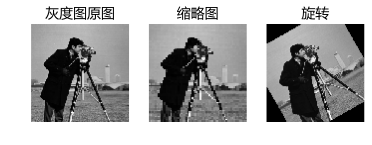

In [49]:
# 读取图片
I = Image.open("cameraman.tif")
figure()
gray()
subplot(131)
imshow(I)
title('灰度图原图', fontproperties=font)
axis('off')
size = 64, 64
# I.resize(size)
# I1 = thumbnail(size) # 图像修改大小,会改变原大小，只能变小
I1 = I.resize(size)  # 图像修改大小，不会修改原来的大小
subplot(132)
imshow(I1)
title("缩略图", fontproperties=font)
axis('off')
I2 = I.rotate(30)
subplot(133)
imshow(I2)
title("旋转", fontproperties=font)
axis('off')
show()

### 图像加噪声

In [50]:
def wgn(x, snr):
    snr = 10**(snr/10.0)
    xpower = np.sum(x**2)/np.size(x)
    npower = xpower / snr
    return x+np.random.randn(x.shape[0], x.shape[1])*np.sqrt(npower)


def PepperAndSalt(x, percentage):
    noise = np.random.rand(x.shape[0], x.shape[1])
    pepper = noise < percentage/2.0
    salt = noise > 1-percentage/2.0
    noise[pepper] = 0
    noise[salt] = 255
    return x+noise

### 加噪声结果

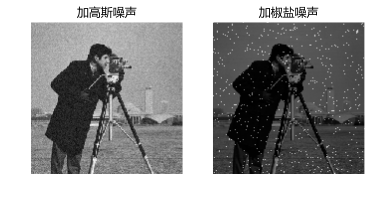

In [139]:
# 加噪声结果
Im = np.array(I)
figure()
subplot(121)
snr = 0
ImGauss = wgn(Im, snr)
imshow(ImGauss)
title('加高斯噪声')
axis('off')
subplot(122)
percent = 0.05
Im_PaS = PepperAndSalt(Im, percent)
imshow(Im_PaS)
title('加椒盐噪声')
axis('off')
show()

### 去噪
#### 几种滤波器
##### 均值滤波器
1. 算数均值滤波器
\begin{equation*}
    \bar{f}(x,y) = \frac{1}{mn}\sum_{(s,t)\in N(x,y)}g(s,t)
\end{equation*}

2. 几何均值滤波器
\begin{equation*}
     \bar{f}(x,y) = \left[\prod_{(s,t)\in N(x,y)}g(s,t)\right]^{\frac{1}{mn}}
\end{equation*}

3. 调和均值滤波器
\begin{equation*}
    \bar{f}(x,y) = \frac{mn}{\sum_{(s,t)\in N(x,y)}1/g(s,t)}
\end{equation*}

4. 逆调和均值滤波器
\begin{equation*}
    \bar{f}(x,y) = \frac{\sum_{(s,t)\in N(x,y)}g^{k+1}(s,t)}{\sum_{(s,t)\in N(x,y)}g^k(s,t)}
\end{equation*}



In [ ]:
#均值滤波器
def AVfilter(X,m,mode = 1):
    if len(m) == 1:
        m.append(m[0])
    dx_all = range(0,m[0])-floor(m[0]/2)
    dy_all = range(0,m[1])-floor(m[1]/2)
    if mode == 1:#算数均值滤波器
        Y = np.zeros(np.shape(X))
        for dx in dx_all:
            for dy in dy_all:
                Y = Y+Trans(X,int(dx),int(dy))
        Y = Y/(m[0]*m[1])
    elif mode == 2:#几何均值滤波器
        Y = np.ones(np.shape(X))
        for dx in dx_all:
            for dy in dy_all:
                Y = np.multiply(Y,Trans(X,int(dx),int(dy),2))
        Y = np.power(Y,1/(m[0]*m[1]))
    elif mode == 3:#调和均值滤波器
        Y = np.zeros(np.shape(X))
        for dx in dx_all:
            for dy in dy_all:
                Y = Y + 1/(Trans(X,int(dx),int(dy))+np.spacing(1))
        Y = (m[0]*m[1])/(Y+np.spacing(1))
    return Y
        
def IAVfilter(X,m,k):
    if len(m) == 1:
        m.append(m[0])
    dx_all = range(0,m[0])-floor(m[0]/2)
    dy_all = range(0,m[1])-floor(m[1]/2)
    Y1 = np.zeros(np.shape(X))
    Y2 = np.zeros(np.shape(X))
    for dx in dx_all:
        for dy in dy_all:
            Y1 = Y1+np.power(Trans(X,int(dx),int(dy),2),k+1)
            Y2 = Y2+np.power(Trans(X,int(dx),int(dy),2),k)
    return Y1/(Y2+np.spacing(1))
        

In [129]:
# 图像平移
def Trans(src,dx,dy,mode = 1):
    if mode == 1:
        Y = np.zeros(np.shape(src))
    else:
        Y = np.ones(np.shape(src))
    if dx > 0:
        if dy >0:
            Y[1+dx:-1,1+dy:-1] = src[1+dx:-1,1+dy:-1]
        else:
            Y[1+dx:-1,1:-1+dy] = src[1+dx:-1,1:-1+dy]   
    else:
        if dy>0:
            Y[1:-1+dx,1+dy:-1] = src[1:-1+dx,1+dy:-1]
        else:
            Y[1:-1+dx,1:-1+dy] = src[1:-1+dx,1:-1+dy]    
    return Y

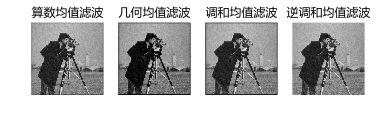

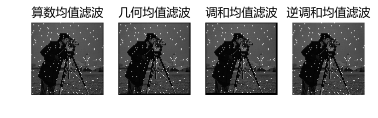

In [142]:
# 对于加高斯噪声的滤波，使用均值类滤波
figure()
subplot(141)
imshow(AVfilter(ImGauss, [5]))
title("算数均值滤波")
axis('off')
subplot(142)
imshow(AVfilter(ImGauss, [6], 2))
title("几何均值滤波")
axis("off")
subplot(143)
imshow(AVfilter(ImGauss, [3], 3))
title("调和均值滤波")
axis("off")
subplot(144)
imshow(IAVfilter(ImGauss, [3], 5))
title("逆调和均值滤波")
axis("off")
show()

# 对于加椒盐噪声的滤波
figure()
subplot(141)
imshow(AVfilter(Im_PaS, [10]))
title("算数均值滤波")
axis('off')
subplot(142)
imshow(AVfilter(Im_PaS, [10], 2))
title("几何均值滤波")
axis("off")
subplot(143)
imshow(AVfilter(Im_PaS, [10], 3))
title("调和均值滤波")
axis("off")
subplot(144)
imshow(IAVfilter(Im_PaS, [10], 5))
title("逆调和均值滤波")
axis("off")
show()